In [41]:
import osmnx as ox
import json


# Nome do bairro, cidade e país
place_name = "L'Esquerra de l'Eixample, Barcelona, Spain"

# Obter o grafo apenas para o bairro desejado
G = ox.graph_from_place(place_name, network_type="drive")

# Verificar as informações do grafo
print(G)

MultiDiGraph with 130 nodes and 221 edges


In [58]:
# 1. Mapear os nós (vértices) a índices numéricos consecutivos
node_to_index = {node: idx for idx, node in enumerate(G.nodes)}

In [57]:

# 2. Estruture os dados no formato desejado
segmentos = []
id_counter = 0

for u, v, data in G.edges(data=True):
    # Adicionar segmento de ida
    segmento_ida = {
        "id": id_counter,
        "vSaida": node_to_index[u],
        "vEntrada": node_to_index[v],
        "imoveis": [],  # Preencher com dados reais de imóveis, se necessário
        "limVel": data.get("maxspeed", "N/A"),  # Limite de velocidade (se disponível)
        "tamanho": int(data.get("length", 0)),  # Comprimento da rua
        "rua": data.get("name", f"Rua desconhecida {id_counter}"),
    }
    id_counter += 1
    segmentos.append(segmento_ida)

    # Adicionar segmento de volta, caso a via seja de mão dupla
    if data.get("oneway", False) is not True:
        segmento_volta = {
            "id": id_counter,
            "vSaida": node_to_index[v],
            "vEntrada": node_to_index[u],
            "imoveis": [],
            "limVel": data.get("maxspeed", "N/A"),
            "tamanho": int(data.get("length", 0)),
            "rua": data.get("name", f"Rua desconhecida {id_counter}"),
        }
        id_counter += 1
        print(segmento_volta)
        segmentos.append(segmento_volta)

# 3. Estruturar os segmentos como lista de adjacência
num_vertices = len(node_to_index)
listaAdj = [[] for _ in range(num_vertices)]

for segmento in segmentos:
    listaAdj[segmento["vSaida"]].append(segmento)

planta_data = {"listaAdj": listaAdj}
planta_data

{'id': 143, 'vSaida': 113, 'vEntrada': 80, 'imoveis': [], 'limVel': '30', 'tamanho': 113, 'rua': 'Carrer del Rosselló'}
{'id': 147, 'vSaida': 84, 'vEntrada': 82, 'imoveis': [], 'limVel': '50', 'tamanho': 150, 'rua': 'Avinguda Diagonal'}
{'id': 150, 'vSaida': 87, 'vEntrada': 82, 'imoveis': [], 'limVel': '50', 'tamanho': 147, 'rua': 'Avinguda Diagonal'}
{'id': 153, 'vSaida': 87, 'vEntrada': 83, 'imoveis': [], 'limVel': '50', 'tamanho': 300, 'rua': 'Avinguda Diagonal'}
{'id': 155, 'vSaida': 82, 'vEntrada': 84, 'imoveis': [], 'limVel': '50', 'tamanho': 150, 'rua': 'Avinguda Diagonal'}
{'id': 157, 'vSaida': 88, 'vEntrada': 84, 'imoveis': [], 'limVel': '50', 'tamanho': 200, 'rua': 'Avinguda Diagonal'}
{'id': 162, 'vSaida': 83, 'vEntrada': 87, 'imoveis': [], 'limVel': '50', 'tamanho': 300, 'rua': 'Avinguda Diagonal'}
{'id': 164, 'vSaida': 82, 'vEntrada': 87, 'imoveis': [], 'limVel': '50', 'tamanho': 147, 'rua': 'Avinguda Diagonal'}
{'id': 166, 'vSaida': 98, 'vEntrada': 88, 'imoveis': [], 'lim

{'listaAdj': [[{'id': 0,
    'vSaida': 0,
    'vEntrada': 1,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 132,
    'rua': 'Gran Via de les Corts Catalanes'},
   {'id': 1,
    'vSaida': 0,
    'vEntrada': 34,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 150,
    'rua': 'Carrer de Casanova'}],
  [{'id': 2,
    'vSaida': 1,
    'vEntrada': 75,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 19,
    'rua': 'Carrer de Muntaner'},
   {'id': 3,
    'vSaida': 1,
    'vEntrada': 105,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 134,
    'rua': 'Gran Via de les Corts Catalanes'}],
  [{'id': 4,
    'vSaida': 2,
    'vEntrada': 3,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 137,
    'rua': 'Carrer de París'},
   {'id': 5,
    'vSaida': 2,
    'vEntrada': 49,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 130,
    'rua': 'Carrer de Villarroel'}],
  [{'id': 6,
    'vSaida': 3,
    'vEntrada': 10,
    'imoveis': [],
    'limVel': '50',
    'tamanho': 

In [43]:
# Colete todos os nomes de ruas únicos
nomes = set()

for segmento in segmentos:
    nome_rua = segmento["rua"]
    if isinstance(nome_rua, list):
        nome_rua = nome_rua[0]  # Converte a lista em uma string concatenada
        segmento["rua"] = nome_rua
    nomes.add(nome_rua)

# Conte a quantidade de nomes únicos
quantidade_ruas_diferentes = len(nomes)

# Exiba o resultado
quantidade_ruas_diferentes


36

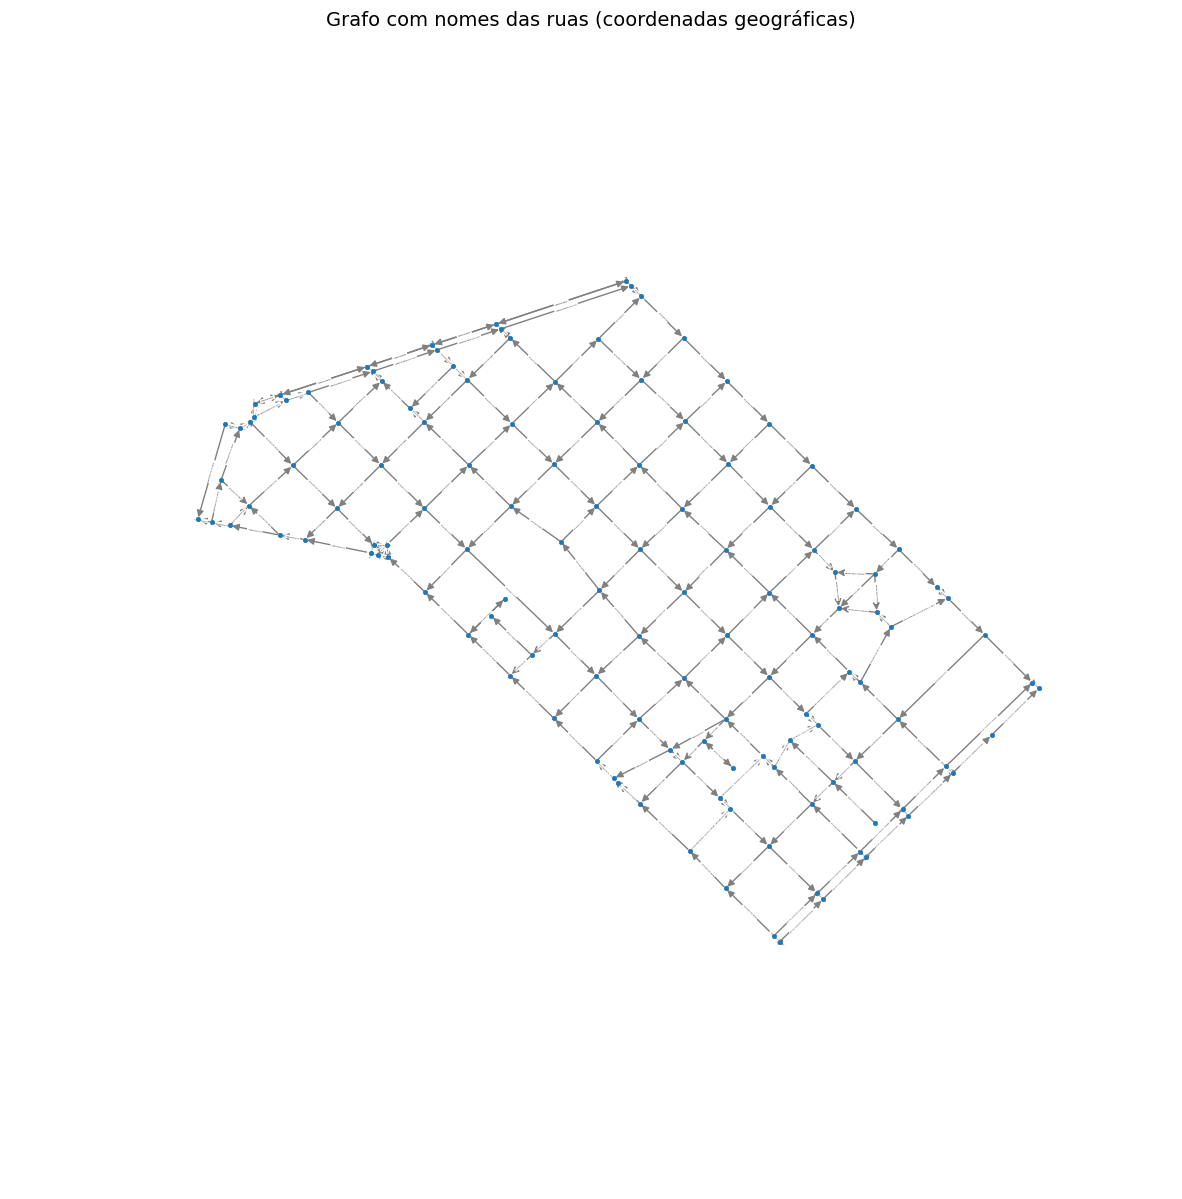

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
# Obter posições reais dos nós no grafo (latitude e longitude)
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}

# Crie um dicionário para associar arestas ao nome das ruas
edge_labels = {
    (u, v): data.get("name", "Rua desconhecida")
    for u, v, data in G.edges(data=True)
}

# Desenhe o grafo com as posições reais
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(
    G,
    pos,
    ax=ax,
    node_size=10,
    edge_color="gray",
    linewidths=0.5,
    with_labels=False,
)

# Adicione rótulos às arestas com os nomes das ruas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=0.1, label_pos=0.5)
plt.title("Grafo com nomes das ruas (coordenadas geográficas)", fontsize=14)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Obter posições reais dos nós no grafo (latitude e longitude)
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}

# Crie um dicionário para associar arestas ao nome das ruas
edge_labels = {
    (u, v): data.get("name", "Rua desconhecida")
    for u, v, data in G.edges(data=True)
}

# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(15, 15))

# Desenhar o grafo com as posições reais
nx.draw(
    G,
    pos,
    ax=ax,
    node_size=10,
    edge_color="gray",
    linewidths=0.5,
    with_labels=False,
)

# Adicionar rótulos às arestas com os nomes das ruas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=1, label_pos=0.5)

# Adicionar números dos vértices (IDs dos nós)
node_labels = {node: str(idx) for idx, node in enumerate(G.nodes)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="red")

# Configurar título e exibir a visualização
plt.title("Grafo com nomes das ruas e números dos vértices (coordenadas geográficas)", fontsize=14)
plt.show()


In [55]:
# 3. Salve no formato JSON
with open("mapa.json", "w", encoding="utf-8") as f:
    json.dump(planta_data, f, ensure_ascii=False, indent=4)